<a href="https://colab.research.google.com/github/HughYau/Research-with-Python/blob/main/Cauculate_Stratified_Sampling_Size_with_Mathematical_Progrming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 需求背景
Y项目通过在抖音投放并收集了3000+份用户问卷，但由于调研渠道和用户特征有偏，不能完全代表广大网民对内容的喜好特征。所以业务同学提出希望按照中国网民的用户特征分布（性别、年龄和学历），对问卷进行再次抽样，然后再对结果进行二次加工计算出提及率和TGI等指标，作为Y项目用户喜好内容决策的方法之一。
具体抽样要求：在抽样的样本特征满足特定分布的情况下尽可能使得抽样份数最大。满足的分布要求如下：
1. 性别：男：女 = 51：49
2. 年龄：
  18-29：21.52%
  30-39：23.74%
  40-49：21.87%
  50-59：18.06%
  60+：14.27%
3. 学历
  小学及以下：19.3%
  初中：40.3%
  高中/中专/技校：20.6%
  大专：10.5%
  本科及以上：9.3%

# 解决方案
解决三个特征限制问题前，我们可以先试着解决两个特征限制，如年龄和性别。
## 直积法
### 方法概述
一个显然的方法是，把二者的特征合并——年龄有5个分类，性别有2个，二者相乘得到总共有10个分类的人群。同时也对条件中的分布情况进行特征合并，即对比例进行张量积（直积）的计算
$$(0.2152,0.2374,0.2187,0.1860,0.1427)⊗(0.51,0.49) = (0.109752, 0.105448, 0.121074, 0.116326, 0.111537, 0.107163,0.09486 , 0.09114 , 0.072777, 0.069923)
$$
即可得到这10类人群的理想分布情况。

最后将10类人群实际样本量除以理想分布，得到用尽该类样本以满足理想分布所需的总抽样量，取其中的最小值（大于该值则该存在类人群的实际样本量不够，造成最后占比小于理想频率）为总抽样量，再乘以理想分布得到各类人群的抽样量，最后对结果取整。
### 实现结果
用EXCEL表示整体流程如下：

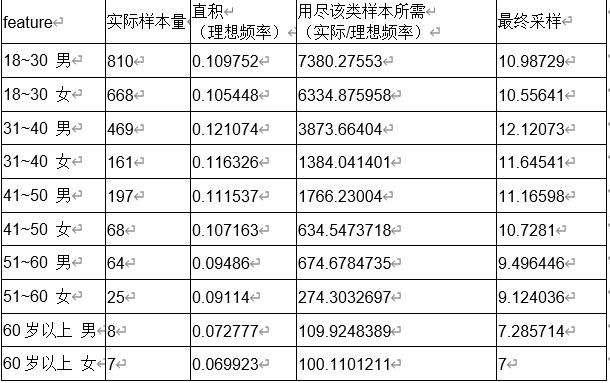

### 存在问题
这种方法比较容易理解，其本质是对原问题的加强，原问题只要求总体样本满足该条件的分布，但用这种方法抽样后，任意限制一个特征的子样本的其他特征分布都是相同且满足条件的。比如抽样后的每个年龄段的群体，其男女比例都会符合51：49，而男女两个性别下，各自的年龄段分布也都是相同且满足题目条件的。这是张量积计算的必然后果，也是将原题的一个比较松弛的条件，强化到一个只存在唯一抽样分布解的情况。
问题在于，每类人群的理想频率在直积后一般不为0，而实际样本中却可能出现一类人样本缺失的问题，那么这部分人永远也无法满足理想频率。如果选择忽略，则实际抽样结果就会与题意产生一些不可控制的偏差。其次如果某类人群在样本占比和理想占比差距较大，尤其样本占比较小时，会产生“木桶效应”，导致总抽样数较小。如上表中的“60岁以上女”仅有7个样本（总共2477），但理想频率为7%，则为了满足该条件，最多抽样数也就为100，其中的“60岁以上女”用尽了全部样本。

## 规划法
我们已经知道直积法是将原始问题转换为一个更强的问题进行求解，那么为什么不直接对原问题进行求解呢？
### 方法概述
原问题的本质是一个有约束的线性规划问题，我们仍然以年龄和性别为特征的10类人群举例，用$
x_{i,j},i \in \{0,1,2,3,4\},j \in \{0,1\}$ 表示每类人群的最终抽样量。则所有的分布限制和条件都可以表述为这样的一个最优化问题：
$$
\max \sum_{i}\sum_{j}x_{i,j}\\
subject\ to:\\
\frac{\sum_i x_{i,j}}{\sum_{i}\sum_{j}x_{i,j}}= GenderProb_j， j \in \{0,1\}（性别分布约束）\\
\frac{\sum_j x_{i,j}}{\sum_{i}\sum_{j}x_{i,j}}= AgeProb_i，i \in \{0,1,2,3,4\}  （年龄分布约束）\\
0\leq x_{i,j} \leq sample\_size_{i,j}（变量约束，不可超过各类人群实际样本量）
$$

事实上，$
x_{i,j}$还应当是整数，但在整数规划问题下采用包含等号约束通常会导致无解。因此我们采用先进行线性规划求解后再进行四舍五入为整数，由于增加了变量自身的约束，四舍五入后的整数解也一定是可行的，我们也可以计算整数解与最优解之间的差异，来进行调整。
实现过程
下面给出这种算法的Python实现，主要用到PuLP这一数学规划求解库。


In [1]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.3 MB 5.1 MB/s 


In [2]:
!pip install pulp
import pulp as plp
import numpy as np
import pandas as pd

#数据导入
sample_size = np.array([810,668,469,161,197,68,64,25,8,7])
genderprob = np.array([0.51,0.49])
ageprob = np.array([0.2152,0.2374,0.2187,0.1860,0.1427])
#算法实现
#two dim
def solve_two_feature(uplist,ageprob,genderprob):
  number = len(uplist)
  agenum = len(ageprob)
  gendernum = len(genderprob)
  opt_model = plp.LpProblem(name="MIP Model")
  # 变量定义，主要用到元组以及列表解析式，这里出现了upBound即为变量自身约束
  x_vars = {(i,j): plp.LpVariable(f'x_{i}_{j}',lowBound = 0,upBound = uplist[i*gendernum+j]) for i in range(agenum) for j in range(gendernum) }
  sum_num = plp.lpSum(x_vars[i,j] for i in range(agenum) for j in range(gendernum))
  # 年龄分布约束
  for i in range(agenum):
    opt_model.addConstraint(
    plp.LpConstraint(e=plp.lpSum(x_vars[i,j] for j in range(gendernum))- ageprob[i]*sum_num,
                      sense=plp.LpConstraintEQ,
                      rhs= 0,
                      name="constraintI{0}".format(i)))
  # 性别分布约束
  for j in range(gendernum):
    opt_model.addConstraint(
    plp.LpConstraint(e=plp.lpSum(x_vars[i,j] for i in range(agenum)) - genderprob[j]*sum_num,
                      sense=plp.LpConstraintEQ,
                      rhs= 0,
                      name="constraintJ{0}".format(j)))

  opt_model.sense = plp.LpMaximize
  opt_model.setObjective(sum_num)
  opt_model.solve()

  print(f'优化结果(总抽样个数)：{plp.value(opt_model.objective)}')
  opt_df = pd.DataFrame.from_dict(x_vars, orient="index", columns = ["variable_object"])
  opt_df.index = pd.MultiIndex.from_tuples(opt_df.index, names=["column_i", "column_j"])
  opt_df.reset_index(inplace=True)
  #实际样本量
  opt_df['total_sample_size'] = uplist 
  #最优抽样量（非整数）
  opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.varValue) 
  #最优抽样量（百分比）
  opt_df['solution_percent'] = opt_df["solution_value"]/plp.value(opt_model.objective) 
  #最优抽样量（取整）
  opt_df['round_solution_value'] = opt_df['solution_value'].apply(lambda x: round(x)) 

  ratioi = opt_df.groupby('column_i').agg('sum').loc[:,['total_sample_size','solution_value','solution_percent','round_solution_value']]
  #取整后最优抽样量（百分比）
  ratioi['round_percent'] = ratioi['round_solution_value']/ratioi['round_solution_value'].sum() 

  ratioj = opt_df.groupby('column_j').agg('sum').loc[:,['total_sample_size','solution_value','solution_percent','round_solution_value']]
  ratioj['round_percent'] = ratioj['round_solution_value']/ratioi['round_solution_value'].sum()

  return opt_model,opt_df,ratioi,ratioj

result = solve_two_feature(sample_size,ageprob,genderprob)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
优化结果(总抽样个数)：105.1156275


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [3]:
result[1]

,column_i,column_j,variable_object,total_sample_size,solution_value,solution_percent,round_solution_value
0,0,0,x_0_0,810,0.000000,0.000000,0
1,0,1,x_0_1,668,22.620883,0.215200,23
2,1,0,x_1_0,469,3.068675,0.029193,3
3,1,1,x_1_1,161,21.885774,0.208207,22
4,2,0,x_2_0,197,22.988788,0.218700,23
5,2,1,x_2_1,68,0.000000,0.000000,0
6,3,0,x_3_0,64,19.551507,0.186000,20
7,3,1,x_3_1,25,0.000000,0.000000,0
8,4,0,x_4_0,8,8.000000,0.076107,8
9,4,1,x_4_1,7,7.000000,0.066593,7


上表给出了各类人群以及其实际样本量和抽样量（取整前后）。

In [4]:
result[2]

,total_sample_size,solution_value,solution_percent,round_solution_value,round_percent
column_i,,,,,
0,1478,22.620883,0.2152,23,0.216981
1,630,24.954450,0.2374,25,0.235849
2,265,22.988788,0.2187,23,0.216981
3,89,19.551507,0.1860,20,0.188679
4,15,15.000000,0.1427,15,0.141509


上表是对年龄约束情况的检查，主要查看取整前后的特征占比的变化情况。

In [5]:
result[3]

,total_sample_size,solution_value,solution_percent,round_solution_value,round_percent
column_j,,,,,
0,1548,53.608970,0.51,54,0.509434
1,929,51.506657,0.49,52,0.490566


性别约束取整后的检查。

### 存在问题
这种方法无法保证每一类人群都会被抽样，比如会出现某一类人群实际样本占比较多，但算出的最优抽样量为0，这是因为该类人群的某一特征已经被其他类人群满足，而选择其他类人群的原因在于需要该类人群满足某一特征的分布需要（比如老年人样本量中较少，但要求中对年龄分布较为均衡，则需要样本中所有的老年人参与抽样，但这些填问卷的老年人往往教育程度较高（选择偏误），这就挤占了其他年龄段的高学历教育人群的抽样量）。
#### 解决方法：
为保证每类人尽可能都被取到，可以在变量自身约束设立下界（lowBound），比如为1，这样虽然使得每类群体至少会被抽样1次，但存在无解的可能性，于是可以设置下界为min（1，f（该类样本数）），f为自定义的函数，通过合理设置可以允许部分人群的下界仍然为0.

当然这样新增约束条件，将会牺牲原本的最大抽样份数，此时的抽样的总份数相比原来会变小。
与直积法一样，产生这种“木桶效应”的本质往往是样本实际分布和要求差别较大导致，因此在做抽样规划前还是应该对样本进行一定的数据观测和分析，或者调整对分布的需求，以达到更好的抽样结果。
## 方法对比
事实上，只要多个特征之间是相互独立，都应该采取规划法进行求解。
直积法是将原问题转化成一个更强的问题，如原问题的限制其实是5+5+2 = 12个，而直积法的限制为5*5*2=50个，恰恰等于了未知量的个数（及人群类别数 50），因此其各类的抽样样本量有唯一解（非整数）。
当然，二者都面临样本分布和需求分布如果差异过大，算出的抽样总数会较小的问题，所以源头上还应该在样本收集过程中注意人群的平衡性。

## 附录：3个特征的解决方法：

In [6]:
count_temp = np.array([810,668,469,161,197,68,64,25,8,7])
count_all = np.array([350,87,219,148,6,336,35,184,110,3,135,74,105,145,10,44,28,42,42,5,42,42,46,63,4,9,20,16,20,3,11,15,14,21,3,5,4,9,6,1,3,1,2,1,1,4,0,1,2,0])
gender = np.array([0.51,0.49])
age = np.array([0.2152,0.2374,0.2187,0.1860,0.1427])
edu = np.array([0.093,0.403,0.105,0.206,0.193])
prob = np.kron(age,gender)
prob = np.kron(prob,edu)
#three dim
uplist = count_all
ageprob = age
genderprob = gender
eduprob = edu
number = len(uplist)
agenum = len(ageprob)
gendernum = len(genderprob)
edunum = len(edu)
opt_model = plp.LpProblem(name="MIP Model")
x_vars = {(i,j,k): plp.LpVariable(f'x{i}{j}{k}',lowBound = 0,upBound = uplist[i*gendernum*edunum+j*edunum+k]) for i in range(agenum) for j in range(gendernum) for k in range(edunum) }
sum_num = plp.lpSum(x_vars[i,j,k] for i in range(agenum) for j in range(gendernum) for k in range(edunum))
for i in range(agenum):
  opt_model.addConstraint(
  plp.LpConstraint(e=plp.lpSum(x_vars[i,j,k] for j in range(gendernum) for k in range(edunum))- ageprob[i]*sum_num,
                    sense=plp.LpConstraintEQ,
                    rhs= 0,
                    name="constraintI{0}".format(i)))
for j in range(gendernum):
  opt_model.addConstraint(
  plp.LpConstraint(e=plp.lpSum(x_vars[i,j,k] for i in range(agenum) for k in range(edunum)) - genderprob[j]*sum_num,
                    sense=plp.LpConstraintEQ,
                    rhs= 0,
                    name="constraintJ{0}".format(j)))
for k in range(edunum):
  opt_model.addConstraint(
  plp.LpConstraint(e=plp.lpSum(x_vars[i,j,k] for i in range(agenum) for j in range(gendernum)) - eduprob[k]*sum_num,
                    sense=plp.LpConstraintEQ,
                    rhs= 0,
                    name="constraintK{0}".format(k)))
objective = plp.lpSum(x_vars[i,j,k] for i in range(agenum) for j in range(gendernum) for k in range(edunum))
opt_model.sense = plp.LpMaximize
opt_model.setObjective(objective)
opt_model.solve()

/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


1